In [1]:
import argparse
from math import log10
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.cuda as cuda

import time
import numpy as np
import os
from RANet_lib import *
from RANet_lib.RANet_lib import *
from RANet_model import RANet as Net
import os
import os.path as osp
from glob import glob

import matplotlib.pyplot as plt
from torchvision import transforms
import PIL.Image as Image
torch.cuda.device_count()

1

In [2]:
net_name = 'RANet'
parser = argparse.ArgumentParser(description='RANet')
parser.add_argument('--deviceID', default=[0], help='device IDs')
parser.add_argument('--threads', type=int, default=16, help='number of threads for data loader to use')
parser.add_argument('--workfolder', default='../models/')
parser.add_argument('--savePName', default=net_name)
parser.add_argument('--net_type', default='single_object')
parser.add_argument('--fp16', default=True)
print('===> Setting ......')
# opt = parser.parse_args()
class args:
    pass
opt = args()
# opt.deviceID = [0]
opt.threads=0
opt.workfolder='../models/'
opt.savePName = net_name
opt.net_type='single_object'
opt.fp16=False

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

try:
    os.mkdir(opt.workfolder)
    print('build working folder: ' + opt.workfolder)
except:
    print(opt.workfolder + 'exists')


print('===> Building model')
############## Choose a model #################
# params='RANet_video_multi.pth'
# params='RANet_encoder_retrain_epoch1.pth'
# params='RANet_multi_basic_train_epoch1.pth'
params = 'RANet_video_multi.pth'

dataset='17train'
save_root='../predictions/RANet_Video_17val'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpus = [i for i in range(torch.cuda.device_count())]
# gpus = [0]
print('using GPUs ID: {}'.format(gpus))

model = Net(pretrained=False, type=opt.net_type)
inSize1 = 480
inSize2 = 864
if dataset in ['16val', '16trainval', '16all']:
    model.set_type('single_object')
    year = '2016'
elif dataset in ['17val', '17test_dev', '17train']:
    model.set_type('multi_object')
    year = '2017'
else:
    assert('dataset error')
checkpoint_load(opt.workfolder + params, model)

# if opt.deviceID==[0]:
#     model_cuda = model.cuda()
# else:
#     model_cuda = nn.DataParallel(model).cuda()
# if opt.fp16:
#     model_cuda = model_cuda.half()
#     model_cuda.fp16 = True

root = '../datasets/DAVIS'
img_mode = '480p'
img_shape = (inSize1,inSize2)

model.cuda()
model.eval()
print("model ready")

===> Setting ......
../models/exists
===> Building model
using GPUs ID: [0]
Single-object mode
Change to multi-object mode
=> Loaded checkpoint '../models/RANet_video_multi.pth'
model ready


In [179]:
##### Load the images and a single annotation
import glob
from PIL import Image
import torchvision.transforms as transforms
import re

class Image_loader():
    def __init__(self, folder_path, img_shape, rand = True):
        
        self.folder_path = folder_path
        self.img_shape = img_shape
        self.file_list = glob.glob(folder_path + "/*jpg")
        self.file_list.sort(key=lambda f: int(re.sub('\D', '', f)))
        self.trans = transforms.ToTensor()
        if rand:
            self.order = np.random.choice([i for i in range(len(self.file_list))], len(self.file_list), replace=False)
        else:
            self.order = np.array([i for i in range(len(self.file_list))])
        self.current_index = 0
    def get_images(self,batch_size):
        img_list = []
        img_names = []
        for i in range(batch_size):
            img = Image.open(self.file_list[self.order[self.current_index]])
            img_names.append(self.file_list[self.order[self.current_index]])
            self.current_index = (self.current_index+1)%len(self.file_list)
            
            img_list.append( self.trans(img.resize(self.img_shape)) )
        img_dataset = torch.stack(img_list)
        return img_dataset, img_names
folder_path = '../../hrnet/HRNet-Semantic-Segmentation/domain2_images'
img_shape = (864,480)
img_loader = Image_loader(folder_path = folder_path, img_shape=img_shape, rand=False)
annot_folder_path = '../../hrnet/HRNet-Semantic-Segmentation/domain2_images/annotations'

annot_file_list = glob.glob(annot_folder_path + "/*npy")
annot_file_list.sort(key=lambda f: int(re.sub('\D', '', f)))
annot_list = []
for i in range(len(annot_file_list)):
    annot_list.append(torch.from_numpy(np.load(annot_file_list[i])))
annot_list = torch.stack(annot_list, dim=0).unsqueeze(0).float()
annot_list= F.interpolate(annot_list, size=(480,864), mode='nearest')
# These annotations are from different classes. So their numbers are not uniformly increasing. Make it so
template_mask = annot_list[:,:1].clone()
annot_map = torch.unique(template_mask)
annot_map.sort()
for i, v in enumerate(annot_map):
    template_mask[template_mask==v] = i
template_mask = template_mask + 2
print("annot_map:", annot_map, "new annot masks:", np.unique(template_mask))
print("template_mask shape:", template_mask.shape)

annot_map: tensor([ 0.,  2.,  5.,  6.,  8., 10., 13.]) new annot masks: [2. 3. 4. 5. 6. 7. 8.]
template_mask shape: torch.Size([1, 1, 480, 864])


In [180]:
images = []
annot_pred = []

img_loader.current_index = 0
template_img, _ = img_loader.get_images(batch_size=1)
template_img = template_img.cuda()

for i in range(11):
    target, _ = img_loader.get_images(batch_size=1)
    target = target.cuda()
    template_mask = template_mask.cuda()
    prev_mask = template_mask

    images.append(target[0].detach().cpu().numpy().transpose(1,2,0))

    with torch.no_grad():
        Out, corr_loss_batch = model.RANet_Multiple_forward_train(template=template_img,target=target,\
                               template_msk=template_mask, target_msk = _,prev_mask=prev_mask,\
                               disc_scale=0) 
    # prediction_single_masks = []
    # target_single_masks = []
    # for idx in range(len(Out)):
    #     max_obj = template_mask[idx,0].max().int().data.cpu().numpy()
    #     for i in range(max_obj-1):
    #         prediction_single_masks.append(Out[idx][0,i].reshape(-1))

    # prediction_single_masks = torch.stack(prediction_single_masks)
    pred_masks = torch.argmax(Out[0], dim=1)
    prev_mask = pred_masks.unsqueeze(0) + 2

    pred_annot = pred_masks[0].detach().cpu().numpy()
    for i in range(len(annot_map)):
        v = annot_map[-(i+1)]
        pred_annot[pred_annot==len(annot_map)-i-1] = v
    #     print("mask: %d converted to: %d"%(len(annot_map)-i-1, v))

    annot_pred.append(pred_annot)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


T_corr shape: torch.Size([1, 405, 30, 54])
T_corr shape: torch.Size([1, 405, 30, 54])
T_corr shape: torch.Size([1, 405, 30, 54])
T_corr shape: torch.Size([1, 405, 30, 54])
T_corr shape: torch.Size([1, 405, 30, 54])
T_corr shape: torch.Size([1, 405, 30, 54])
T_corr shape: torch.Size([1, 405, 30, 54])
T_corr shape: torch.Size([1, 405, 30, 54])
T_corr shape: torch.Size([1, 405, 30, 54])
T_corr shape: torch.Size([1, 405, 30, 54])
T_corr shape: torch.Size([1, 405, 30, 54])


In [ ]:
3*len(t_list))+3

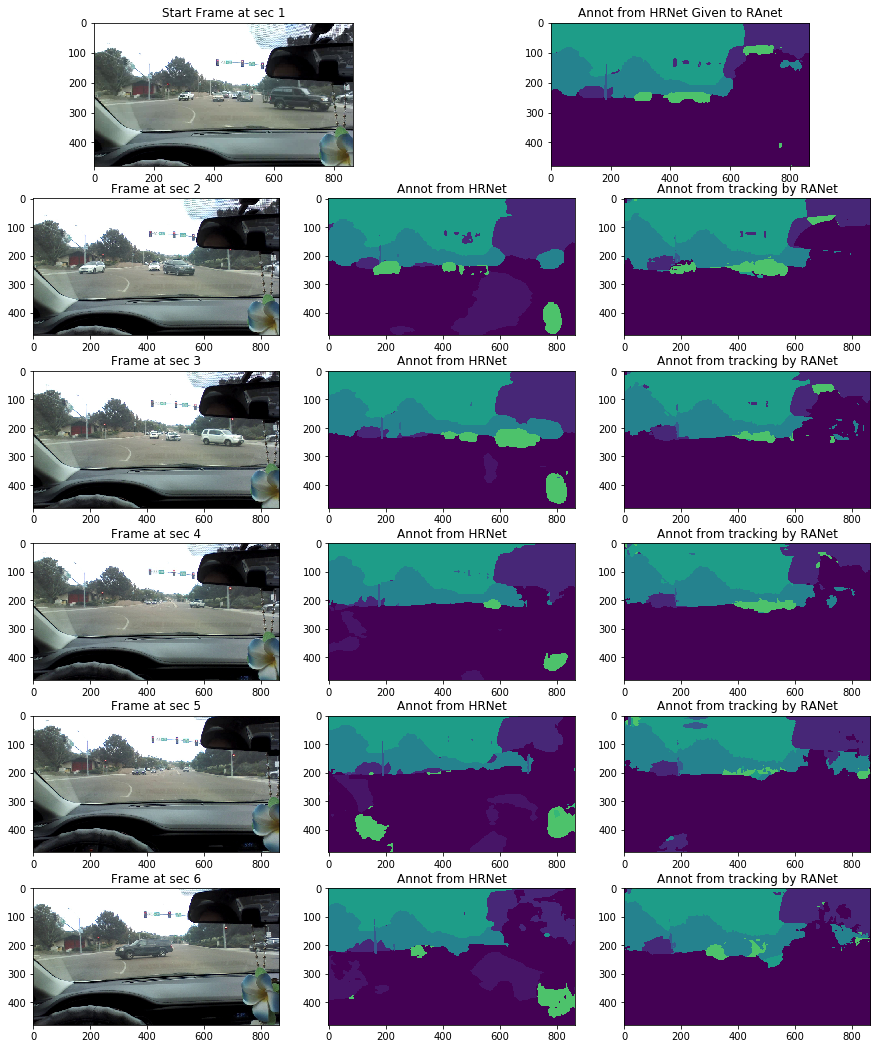

In [190]:
t_list = [0,1, 2, 3, 4]

plt.figure(figsize=(15,3.1*len(t_list)+3))
plt.subplot(len(t_list)+1,2, 1)
plt.imshow(template_img[0].detach().cpu().numpy().transpose(1,2,0))
plt.title("Start Frame at sec 1" )

plt.subplot(len(t_list)+1,2, 2)
plt.imshow(annot_list[0,0].detach().cpu().numpy(), vmin=0, vmax=18)
plt.title("Annot from HRNet Given to RAnet")

# plt.subplot(len(t_list)+1,3, 3)
# plt.imshow(annot_pred[i], vmin=0, vmax=18)
# plt.title("Annot from tracking by RANet")
idx = 0
for i in t_list:
    idx += 1
    plt.subplot(len(t_list)+1,3, idx*3+ 1)
    plt.imshow(images[i])
    plt.title("Frame at sec " + str(i+2))
    plt.subplot(len(t_list)+1,3, idx*3+2)
    plt.imshow(annot_list[0,i+1].detach().cpu().numpy(), vmin=0, vmax=18)
    plt.title("Annot from HRNet")

    plt.subplot(len(t_list)+1,3, idx*3+3)
    plt.imshow(annot_pred[i], vmin=0, vmax=18)
    plt.title("Annot from tracking by RANet")

plt.show()

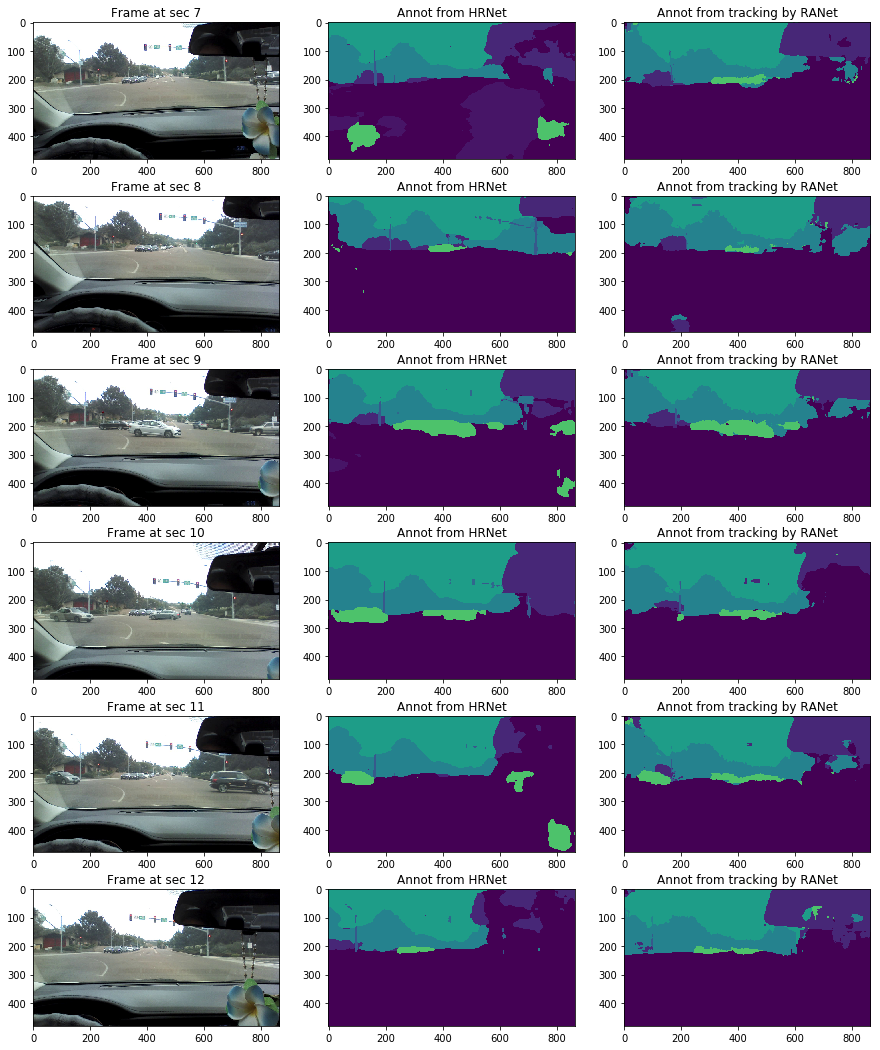

In [189]:
t_list = [5,6, 7, 8, 9,10]

plt.figure(figsize=(15,3.1*len(t_list)))
idx = -1
for i in t_list:
    idx += 1
    plt.subplot(len(t_list),3, idx*3+ 1)
    plt.imshow(images[i])
    plt.title("Frame at sec " + str(i+2))
    plt.subplot(len(t_list),3, idx*3+2)
    plt.imshow(annot_list[0,i+1].detach().cpu().numpy(), vmin=0, vmax=18)
    plt.title("Annot from HRNet")

    plt.subplot(len(t_list),3, idx*3+3)
    plt.imshow(annot_pred[i], vmin=0, vmax=18)
    plt.title("Annot from tracking by RANet")

plt.show()

### Single object tracking

Tracking the flower in dashboard

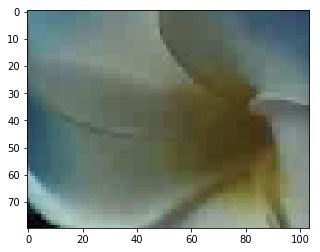

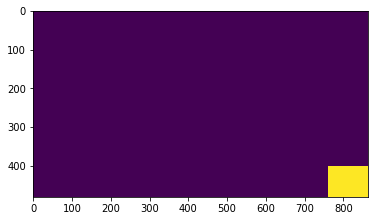

In [145]:
### Prepare mask
plt.figure()
plt.imshow(template_img[0,:, 400:,760:].detach().cpu().numpy().transpose(1,2,0))
template_mask = template_mask*0 + 1
template_mask[0,0, 400:,760:] =2
plt.figure()
plt.imshow(template_mask[0,0].detach().cpu().numpy())

In [164]:


images = []
annot_pred = []

img_loader.current_index = 0
template_img, _ = img_loader.get_images(batch_size=1)
template_img = template_img.cuda()

for i in range(11):
    target, _ = img_loader.get_images(batch_size=1)
    target = target.cuda()
    template_mask = template_mask.cuda()
    prev_mask = template_mask

    images.append(target[0].detach().cpu().numpy().transpose(1,2,0))

    with torch.no_grad():
        Out, corr_loss_batch = model.RANet_Multiple_forward_train(template=template_img,target=target,\
                               template_msk=template_mask, target_msk = _,prev_mask=prev_mask,\
                               disc_scale=0) 
    # prediction_single_masks = []
    # target_single_masks = []
    # for idx in range(len(Out)):
    #     max_obj = template_mask[idx,0].max().int().data.cpu().numpy()
    #     for i in range(max_obj-1):
    #         prediction_single_masks.append(Out[idx][0,i].reshape(-1))

    # prediction_single_masks = torch.stack(prediction_single_masks)
#     pred_masks = torch.argmax(Out[0], dim=1)
    prev_mask = Out[0].ge(0.5).float() + 1

    pred_annot = prev_mask[0,0].detach().cpu().numpy() -1

    #     print("mask: %d converted to: %d"%(len(annot_map)-i-1, v))

    annot_pred.append(pred_annot)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


T_corr shape: torch.Size([1, 405, 30, 54])
T_corr shape: torch.Size([1, 405, 30, 54])
T_corr shape: torch.Size([1, 405, 30, 54])
T_corr shape: torch.Size([1, 405, 30, 54])
T_corr shape: torch.Size([1, 405, 30, 54])
T_corr shape: torch.Size([1, 405, 30, 54])
T_corr shape: torch.Size([1, 405, 30, 54])
T_corr shape: torch.Size([1, 405, 30, 54])
T_corr shape: torch.Size([1, 405, 30, 54])
T_corr shape: torch.Size([1, 405, 30, 54])
T_corr shape: torch.Size([1, 405, 30, 54])


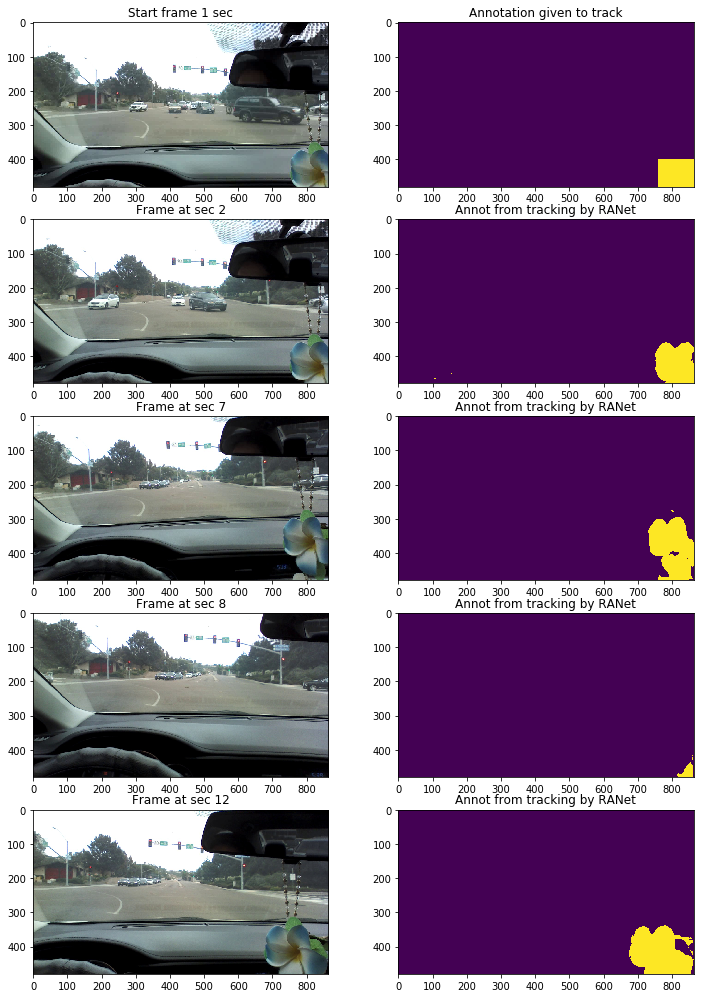

In [178]:
t_list = [0, 5,6,10]
plt.figure(figsize=(12 ,3.5*(len(t_list)+1)))
plt.subplot(len(t_list)+1,2,1)
plt.imshow(template_img[0].detach().cpu().numpy().transpose(1,2,0))
plt.title("Start frame 1 sec")

plt.subplot(len(t_list)+1,2,2)
plt.imshow(template_mask[0,0].detach().cpu().numpy() -1, vmin=0, vmax=1)
plt.title("Annotation given to track")

idx = 0
for i in t_list:
    idx += 1
#     plt.figure(figsize=(10,4))
    plt.subplot(len(t_list)+1, 2, idx*2+ 1)
    plt.imshow(images[i])
    plt.title("Frame at sec " + str(i+2))
#     plt.subplot(1,3,2)
#     plt.imshow(annot_list[0,i+1].detach().cpu().numpy(), vmin=0, vmax=18)
#     plt.title("Annot from HRNet")

    plt.subplot(len(t_list)+1, 2,idx*2+ 2)
    plt.imshow(annot_pred[i], vmin=0, vmax=1)
    plt.title("Annot from tracking by RANet")

plt.show()